In [1]:
import json
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn import metrics

In [141]:
file = '../data_resources/topics/kamerstukken/kamerstukken_topics.json'
data = json.load(open(file))

corpus = []
y = []


for obj in data:
    if not obj['category'] == 'NOCAT' and not obj['content'] == 'NOCONTENT':
        corpus.append(obj['content'])
        y.append(obj['category'])

        
print(len(data))
print(len(corpus))
Counter(y)

16699
16695


Counter({'Bestuur | De Nederlandse Antillen en Aruba': 85,
         'Bestuur | Gemeenten': 236,
         'Bestuur | Koninklijk Huis': 30,
         'Bestuur | Organisatie en beleid': 206,
         'Bestuur | Parlement': 76,
         'Bestuur | Provincies': 9,
         'Bestuur | Rijksoverheid': 63,
         'Bestuur | Waterschappen': 17,
         'Cultuur en recreatie | Cultuur': 63,
         'Cultuur en recreatie | Kunst': 20,
         'Cultuur en recreatie | Media': 166,
         'Cultuur en recreatie | Organisatie en beleid': 30,
         'Cultuur en recreatie | Recreatie': 22,
         'Cultuur en recreatie | Religie': 211,
         'Cultuur en recreatie | Sport': 154,
         'Economie | Bouwnijverheid': 37,
         'Economie | Handel': 229,
         'Economie | ICT': 159,
         'Economie | Industrie': 42,
         'Economie | Markttoezicht': 114,
         'Economie | Ondernemen': 161,
         'Economie | Organisatie en beleid': 124,
         'Economie | Overige economische s

In [149]:
topics = []

for obj in y:
    main = obj.split(" | ")[0]
    sub = obj.split(" | ")[1]

    if not main in topics:
        topics.append({'name' : main, 'sub' : []})
    

    topics[main]['sub'].append(sub)

TypeError: list indices must be integers or slices, not str

In [136]:
from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer(language='dutch')
import re

def pre_process(document):
    return re.sub('[0-9]+', '', document)

transformer = TfidfVectorizer(smooth_idf=True, min_df=0.000001, max_df=0.2, preprocessor=pre_process, sublinear_tf=True)

In [137]:
X_train_corpus, X_test_corpus, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

X_train = transformer.fit_transform(X_train_corpus)
X_test = transformer.transform(X_test_corpus)

print(np.shape(X_train))
print(np.shape(y_test))

(13356, 113812)
(3339,)


In [138]:
clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10, tol=None)
%time clf = OneVsRestClassifier(clf).fit(X_train, y_train)

%time y_pred = clf.predict(X_test)

proba = clf.predict_proba(X_test[0])
print(len(proba[0]))

score = accuracy_score(y_test, y_pred)

print(score)

CPU times: user 28.8 s, sys: 20 ms, total: 28.8 s
Wall time: 28.8 s
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 164 ms
111
0.7867625037436358


In [117]:
transformer.get_feature_names()

['ABN',
 'ABP',
 'ABRvS',
 'ACM',
 'ACP',
 'AD',
 'ADHD',
 'ADR',
 'ADV',
 'AFM',
 'AIVD',
 'AMC',
 'AMRO',
 'AMSTERDAM',
 'AMvB',
 'ANBI',
 'ANBO',
 'ANP',
 'ANVS',
 'ANWB',
 'AO',
 'AOW',
 'AP',
 'APA',
 'APK',
 'APV',
 'ATR',
 'AVV',
 'AVVN',
 'AWBZ',
 'AZC',
 'Aa',
 'Aan',
 'Aanbestedingswet',
 'Aanbieders',
 'Aandacht',
 'Aangezien',
 'Aangifte',
 'Aanhangsel',
 'Aanhangsels',
 'Aanleiding',
 'Aanpak',
 'Aantal',
 'Aanvragen',
 'Aanvullend',
 'Aanvullende',
 'Aanwijzing',
 'Aardbevingen',
 'Aardbevingsschade',
 'Aardolie',
 'Abellio',
 'Academisch',
 'Access',
 'Accountants',
 'Achmea',
 'Acht',
 'Achterhoek',
 'Act',
 'Actal',
 'ActiZ',
 'Actie',
 'Actieplan',
 'Actieprogramma',
 'Action',
 'Activiteitenbesluit',
 'Actiz',
 'Actueel',
 'Acute',
 'Ad',
 'Administratie',
 'Advance',
 'Advies',
 'Adviescollege',
 'Adviescommissie',
 'Advisering',
 'Advocaten',
 'Aedes',
 'Afdeling',
 'Affairs',
 'Afgelopen',
 'Afgesproken',
 'Afghaanse',
 'Afghanistan',
 'Afhankelijk',
 'Africa',
 '

In [139]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/rothweiler/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

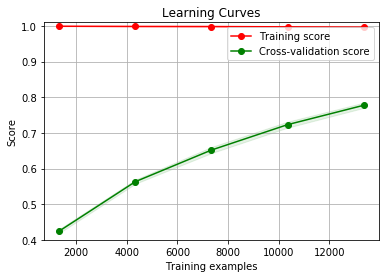

In [140]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

X = transformer.fit_transform(corpus)
plot_learning_curve(clf, title, X, y, ylim=(0.4, 1.01), cv=cv, n_jobs=5)